# Load module

In [1]:
import sys
sys.path.append('../')

from data import datasets
from data import transforms, utils

from models.ssd300 import SSD300
from models.core.loss import SSDLoss
from models.core.train import *
from models.core.graph import LiveGraph

#from torchvision import transforms > not import!!
from torch.utils.data import DataLoader
from torch.optim.sgd import SGD

# Load Dataset

In [2]:
transform = transforms.Compose(
        [transforms.Ignore(difficult=True),
         transforms.Normalize(),
         transforms.Centered(),
         transforms.Resize((300, 300)), # if resizing first, can't be normalized
         transforms.SubtractMean((123.68, 116.779, 103.939)),
         transforms.OneHot(class_nums=datasets.VOC_class_nums),
         transforms.ToTensor()]
    )
train_dataset = datasets.VOC2007Dataset(transform=transform)

train_loader = DataLoader(train_dataset,
                          batch_size=32,
                          shuffle=True,
                          collate_fn=utils.batch_ind_fn)
print('{} training images'.format(len(train_dataset)))

9963 training images


# Define model

In [3]:
model = SSD300(class_nums=train_dataset.class_nums, batch_norm=False)
model.load_vgg_weights()
print(model)

SSD300(
  (feature_layers): ModuleDict(
    (conv1_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu1_1): ReLU()
    (conv1_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu1_2): ReLU()
    (pool1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (conv2_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu2_1): ReLU()
    (conv2_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu2_2): ReLU()
    (pool2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (conv3_1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu3_1): ReLU()
    (conv3_2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu3_2): ReLU()
    (conv3_3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu3_3): ReLU()
    (pool3): MaxPool2d(kernel_size=

# Set matplotlib for Jupyter notebook

In [4]:
%matplotlib notebook

# Run training

<IPython.core.display.Javascript object>


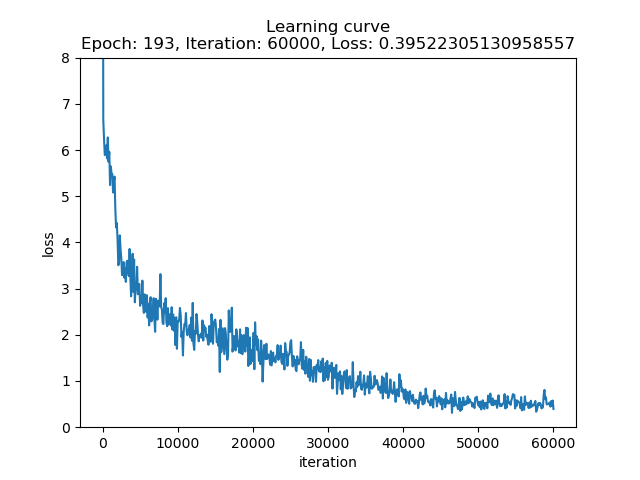


Iteration reached milestone: 40000. Change lr=[0.001] to [0.0001]


Iteration reached milestone: 50000. Change lr=[0.0001] to [1e-05]

Training finished
Saved model to /home/kado/Desktop/program/machile-learning/pytorch_SSD/weights/ssd300-voc2007-separated_i-60000.pth


<IPython.core.display.Javascript object>


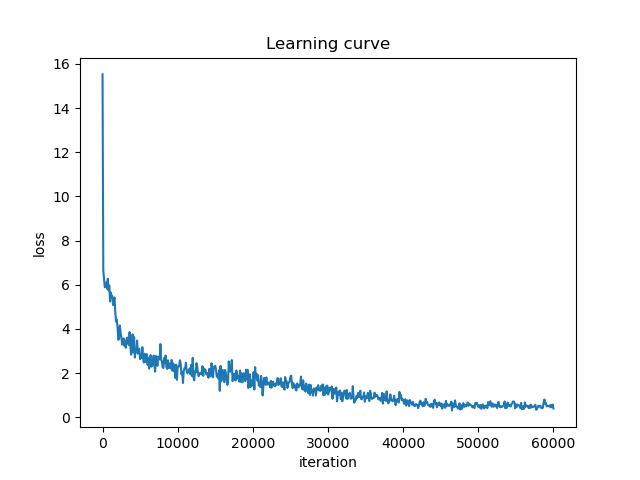

Saved graph to /home/kado/Desktop/program/machile-learning/pytorch_SSD/weights/ssd300-voc2007-separated_learning-curve_i-60000.png


In [5]:
optimizer = SGD(model.parameters(), lr=1e-3, momentum=0.9, weight_decay=5e-4)
iter_sheduler = SSDIterMultiStepLR(optimizer, milestones=(40000, 50000), gamma=0.1, verbose=True)
trainer = Trainer(model, loss_func=SSDLoss(), optimizer=optimizer, sheduler=iter_sheduler, gpu=True, live_graph=True, plot_yrange=(0, 8))
trainer.train(60000, train_loader, savemodelname='ssd300-voc2007', checkpoints_iteration_interval=5000)
#trainer.train(70, train_loader, checkpoints_interval=5, max_checkpoints=3)
# i don't understand drawing delayed one iteration...